# 11_Radial_Basis_Kernel

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from src.plot import plot_spatial, palette_celltype, plot_obs_spatial
import pandas as pd
import numpy as np
palette_entity_anno = palette_celltype.copy()
palette_entity_anno['gene'] = "lightgray"
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [3]:
import os
import simba as si
si.__version__

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_simba_only/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'1.2'

In [4]:
workdir = 'data/11'
si.settings.set_workdir(workdir)

Saving results in: data/11


In [5]:
si.settings.set_figure_params(
    dpi=80,
    style='white',
    fig_size=[5,5],
    rc={'image.cmap': 'viridis'}
)

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

# RBF

In [6]:
from sklearn.metrics.pairwise import rbf_kernel

In [7]:
adata_fn = "/data/pinello/PROJECTS/2025-01-31_CC_Spatial_SIMBA/SIMBA_in_space/data/human_DLPFC/151507.h5ad"
adata = sc.read_h5ad(adata_fn)

In [17]:
gamma = 1e-6
K = rbf_kernel(X=adata.obsm['spatial'], gamma=gamma)

In [18]:
K

array([[1.00000000e+00, 1.60720699e-31, 2.78493682e-02, ...,
        1.47753054e-23, 1.36459981e-13, 1.49194596e-03],
       [1.60720699e-31, 1.00000000e+00, 1.17362583e-21, ...,
        5.10352826e-12, 1.85540707e-12, 1.34044357e-17],
       [2.78493682e-02, 1.17362583e-21, 1.00000000e+00, ...,
        2.55087631e-21, 3.01856368e-12, 5.86336748e-01],
       ...,
       [1.47753054e-23, 5.10352826e-12, 2.55087631e-21, ...,
        1.00000000e+00, 3.80212525e-02, 3.88279699e-19],
       [1.36459981e-13, 1.85540707e-12, 3.01856368e-12, ...,
        3.80212525e-02, 1.00000000e+00, 6.53825966e-11],
       [1.49194596e-03, 1.34044357e-17, 5.86336748e-01, ...,
        3.88279699e-19, 6.53825966e-11, 1.00000000e+00]])

In [10]:
adata.obsm['spatial']

array([[3276, 2514],
       [9178, 8520],
       [5133, 2878],
       ...,
       [4218, 9703],
       [4017, 7906],
       [5683, 3359]])

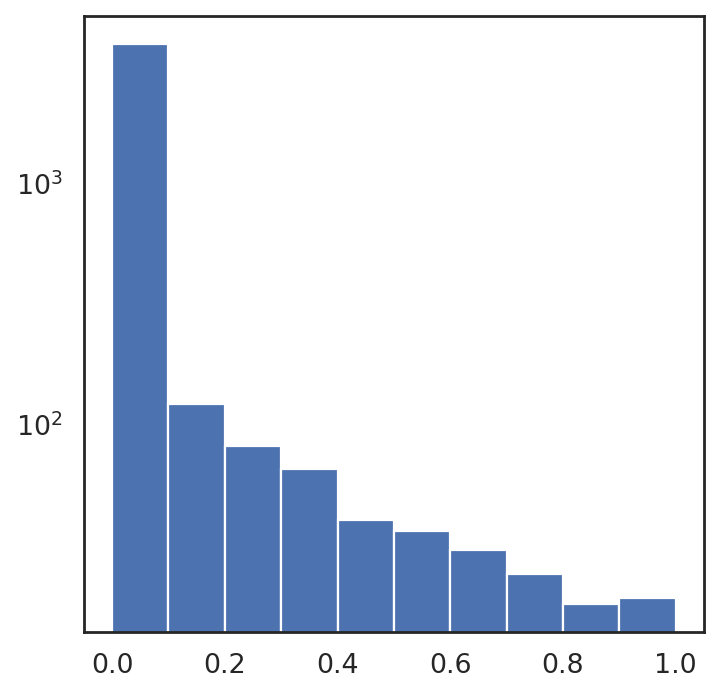

In [11]:
plt.hist(K[500, :])
plt.yscale('log')
plt.show()

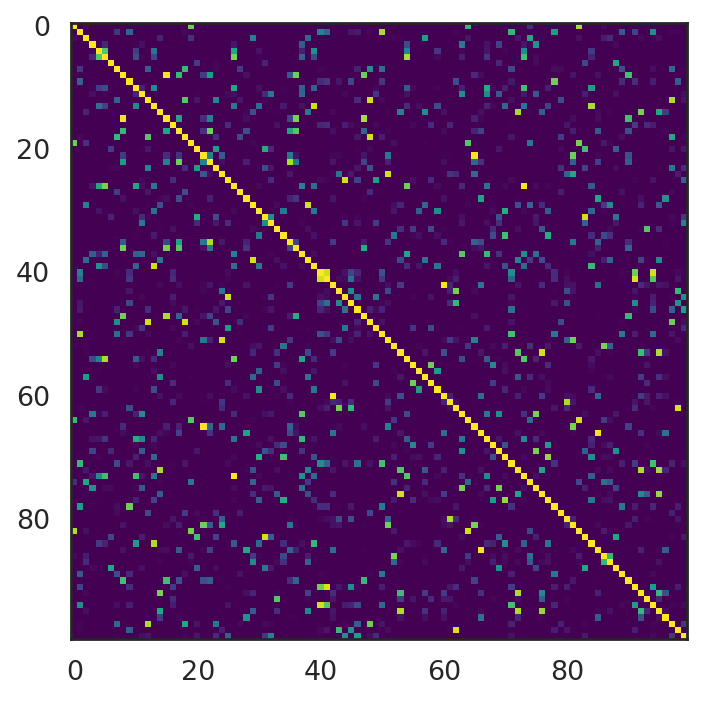

In [12]:
plt.imshow(K[:100, :100])

In [13]:
spots = adata.obsm['spatial'].copy()

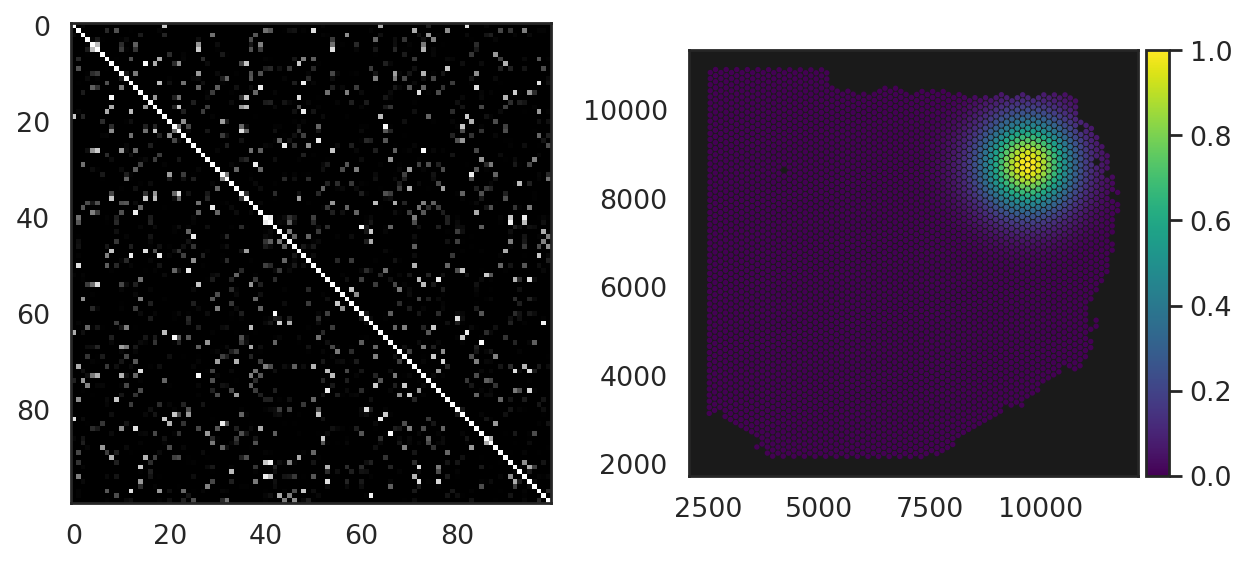

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(8, 12))
axes[0].imshow(K[:100, :100], cmap='gray')

im = axes[1].scatter(spots[:, 1], spots[:, 0], c=K[1500], s=2)
axes[1].set_facecolor('k')
axes[1].set_aspect('equal', adjustable='box')

divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
plt.tight_layout()
plt.show()

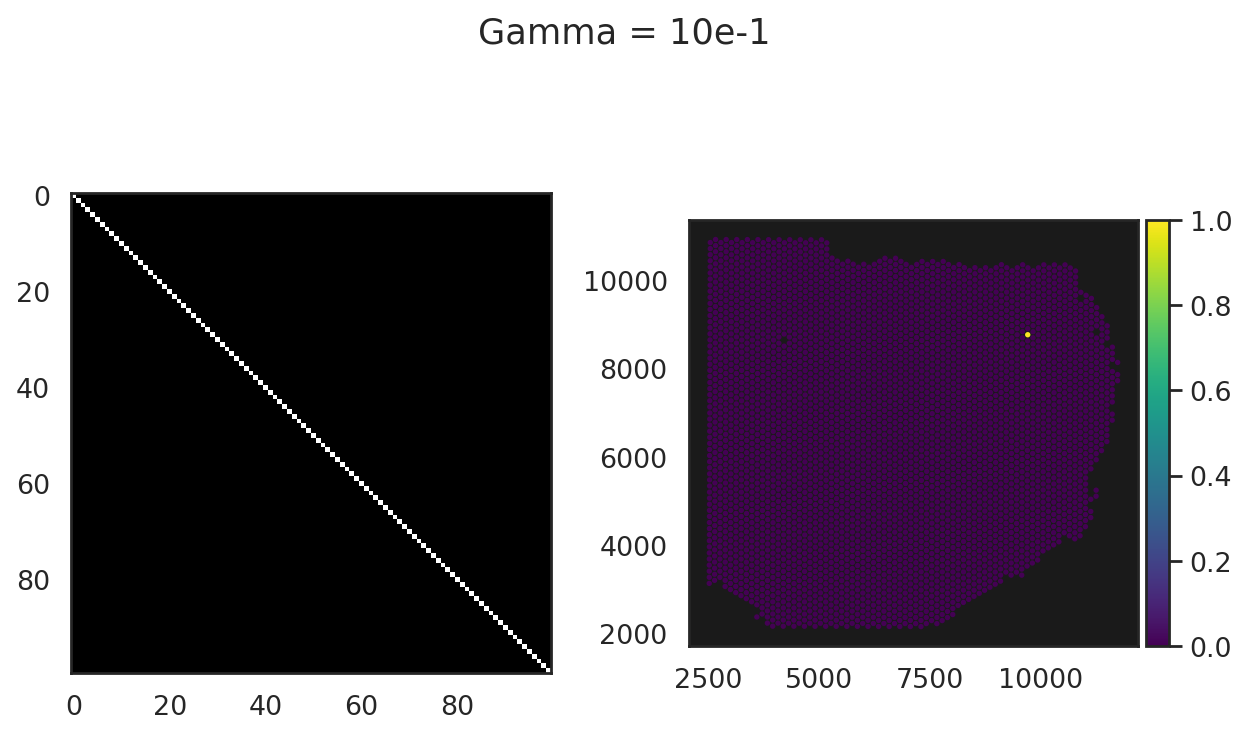

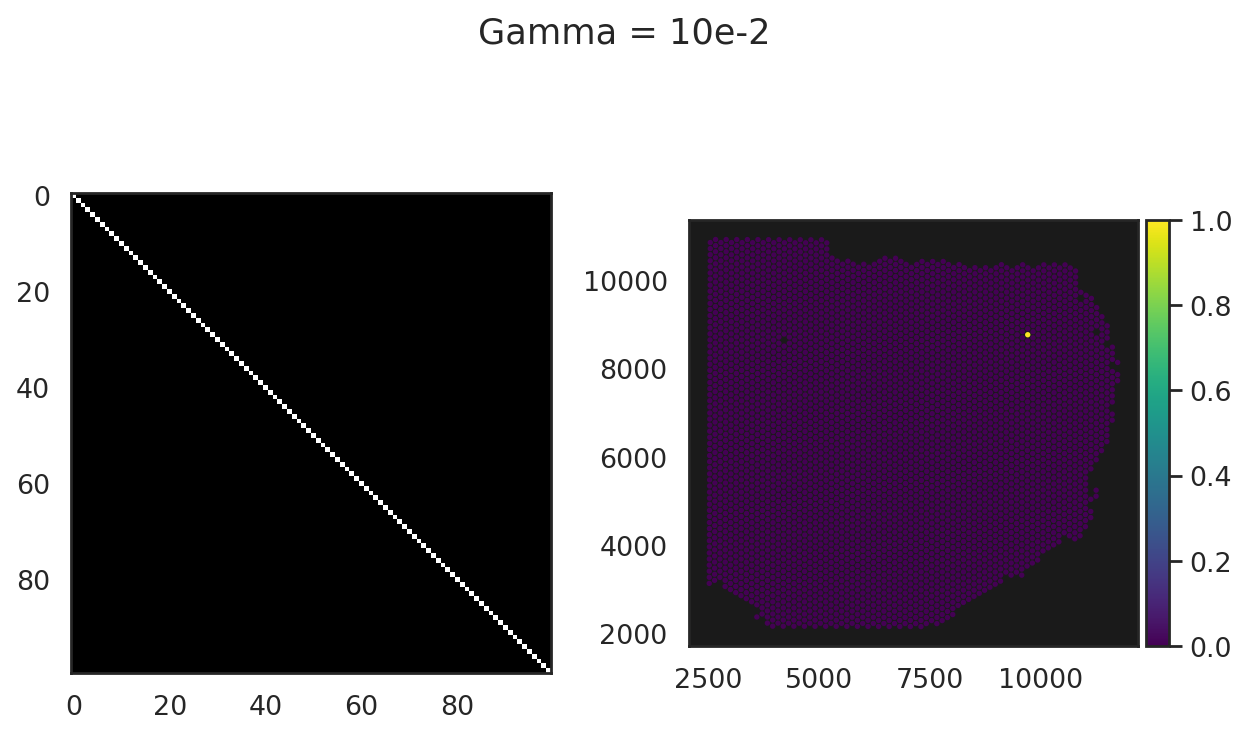

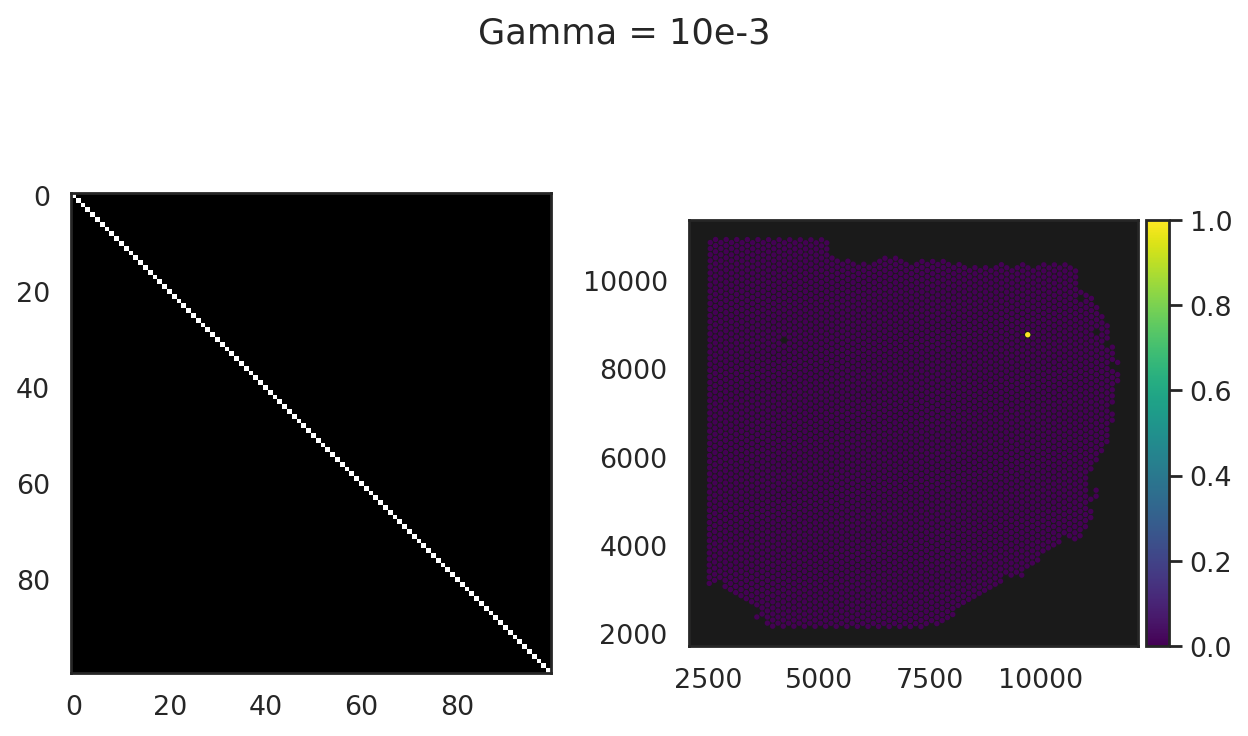

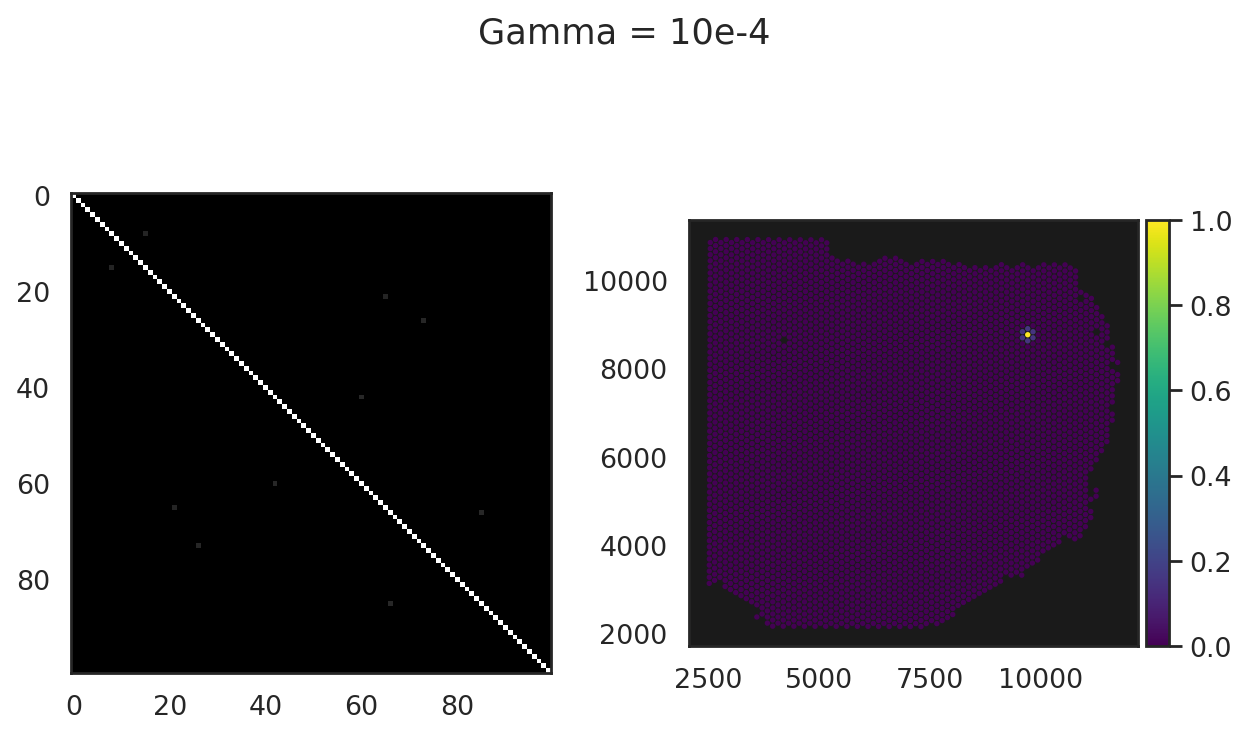

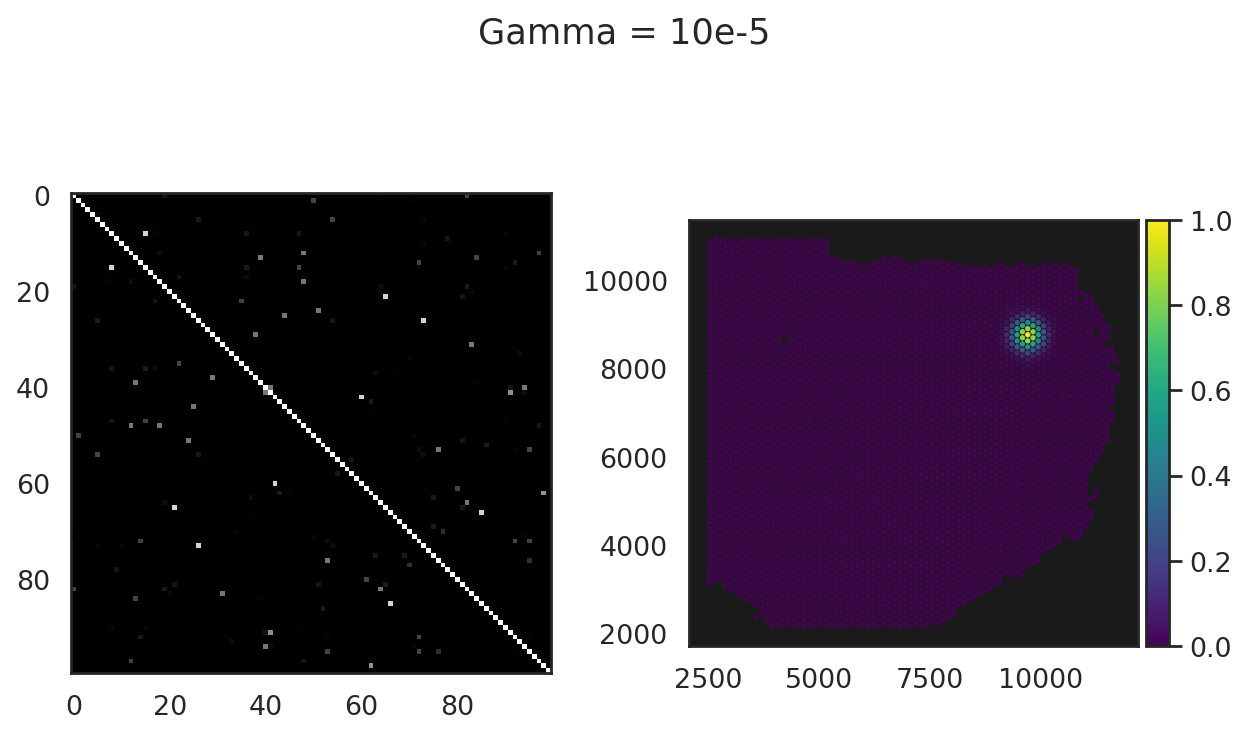

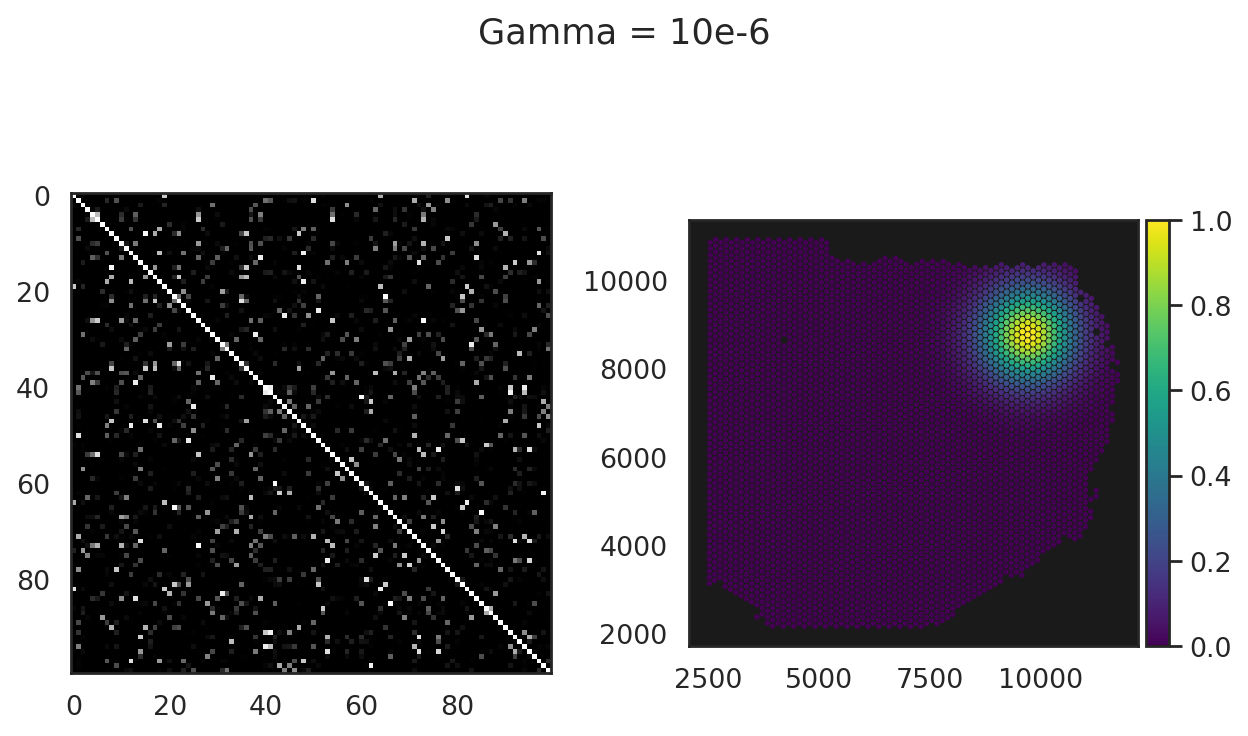

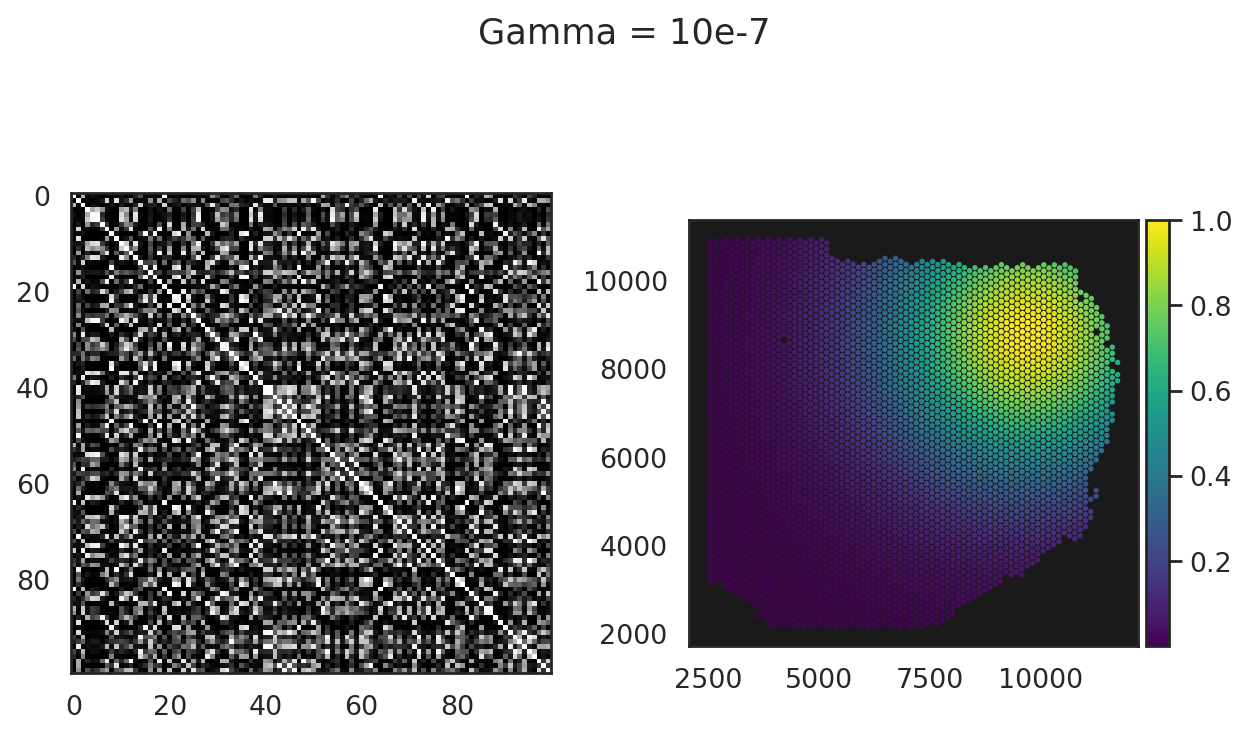

In [20]:
for e in range(1, 8):
    gamma = 10**(-e)
    K = rbf_kernel(X=adata.obsm['spatial'], gamma=gamma)
    fig, axes = plt.subplots(1, 2, figsize=(8, 12))
    axes[0].imshow(K[:100, :100], cmap='gray')

    im = axes[1].scatter(spots[:, 1], spots[:, 0], c=K[1500], s=2)
    axes[1].set_facecolor('k')
    axes[1].set_aspect('equal', adjustable='box')
    fig.suptitle(f"Gamma = 10e-{e}", y=0.7)
    
    divider = make_axes_locatable(axes[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    plt.tight_layout()
    plt.show()

# Test SIMBA



In [47]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import anndata as ad
from scipy.sparse import csr_matrix

def gen_spatial_graph(
    adata,
    e=5, # magnitude
    scalar=1, # could be gene expression correlation?
):
    # gaussian kernel
    spots = adata.obsm['spatial']

    gamma = 10**(-e)
    K = rbf_kernel(X=adata.obsm['spatial'], gamma=gamma)
    K = csr_matrix(K * scalar, dtype=np.float32)

    adata_CC = ad.AnnData(K)
    # adata_CC.layers['simba'] = adata_CC.X

    adata_CC.obs.index = adata.obs_names
    adata_CC.var.index = adata.obs_names
    adata_CC.obs = adata.obs.copy()
    adata_CC.obsm['spatial'] = adata.obsm['spatial'].copy()
    return adata_CC
    

In [79]:
adata_CC = gen_spatial_graph(adata, e = 5)

In [80]:
adata_CC

AnnData object with n_obs × n_vars = 4221 × 4221
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'spatialLIBD', 'leiden'
    obsm: 'spatial'

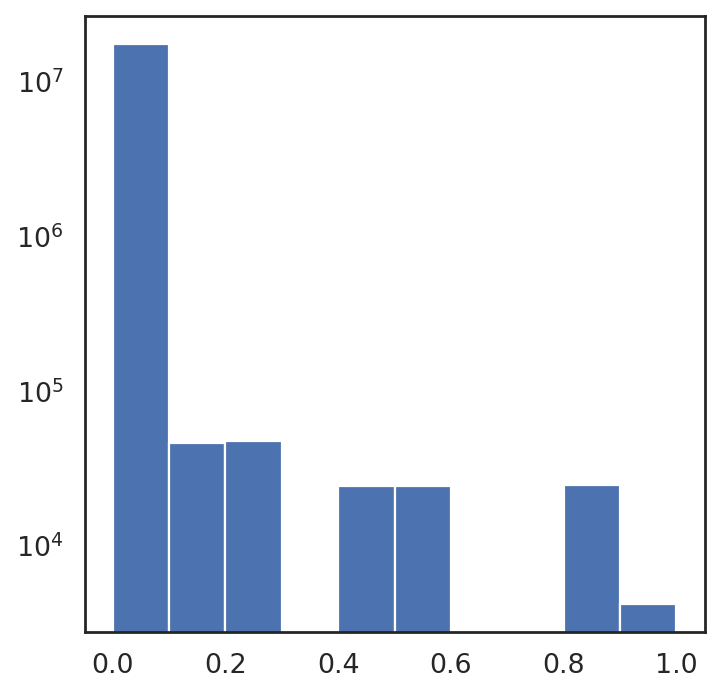

In [81]:
plt.hist(adata_CC.X.toarray().flatten(), bins=10)
plt.yscale('log')

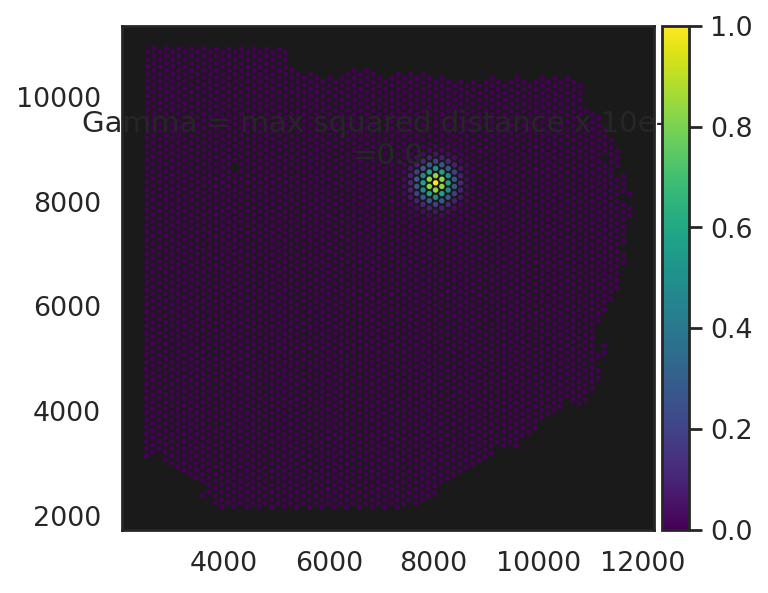

In [82]:
fig, ax = plt.subplots()
im = ax.scatter(adata_CC.obsm['spatial'][:, 1], adata_CC.obsm['spatial'][:, 0], c=adata_CC.X.toarray()[500], s=2)
ax.set_facecolor('k')
ax.set_aspect('equal', adjustable='box')
ax.set_title(f"Gamma = max squared distance x 10e-{e} \n={np.round(gamma, 2)}", y=0.7)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
plt.tight_layout()
plt.show()

In [83]:
# si.tl.discretize(adata_CC,n_bins=5)
# si.pl.discretize(adata_CC,kde=False)

In [84]:
si.tl.gen_graph(
    list_adata=[adata_CC],
    prefix='C',
    # layer='simba',
    use_highly_variable=False, 
    dirname='graph_no_discretize'
)

`simba` does not exist in adata 0 in `list_adata`.`.X` is being used instead.
relation0: source: C0, destination: C0
#edges: 5843305
Total number of edges: 5843305
Writing graph file "pbg_graph.txt" to "data/11/pbg/graph_no_discretize" ...
Finished.


In [85]:
si.tl.pbg_train(auto_wd=True, save_wd=True, output='model_no_discretize')

Auto-estimated weight decay is 6.064231E-03
`.settings.pbg_params['wd']` has been updated to 6.064231E-03
Converting input data ...
[2025-02-18 20:42:24.969953] Using the 1 relation types given in the config
[2025-02-18 20:42:24.970360] Searching for the entities in the edge files...
[2025-02-18 20:42:31.878220] Entity type C0:
[2025-02-18 20:42:31.878699] - Found 4221 entities
[2025-02-18 20:42:31.878981] - Removing the ones with fewer than 1 occurrences...
[2025-02-18 20:42:31.879711] - Left with 4221 entities
[2025-02-18 20:42:31.879962] - Shuffling them...
[2025-02-18 20:42:31.882572] Preparing counts and dictionaries for entities and relation types:
[2025-02-18 20:42:32.097717] - Writing count of entity type C0 and partition 0
[2025-02-18 20:42:32.206600] Preparing edge path data/11/pbg/graph_no_discretize/input/edge, out of the edges found in data/11/pbg/graph_no_discretize/pbg_graph.txt
using fast version
[2025-02-18 20:42:32.209114] Taking the fast train!
[2025-02-18 20:42:32.6

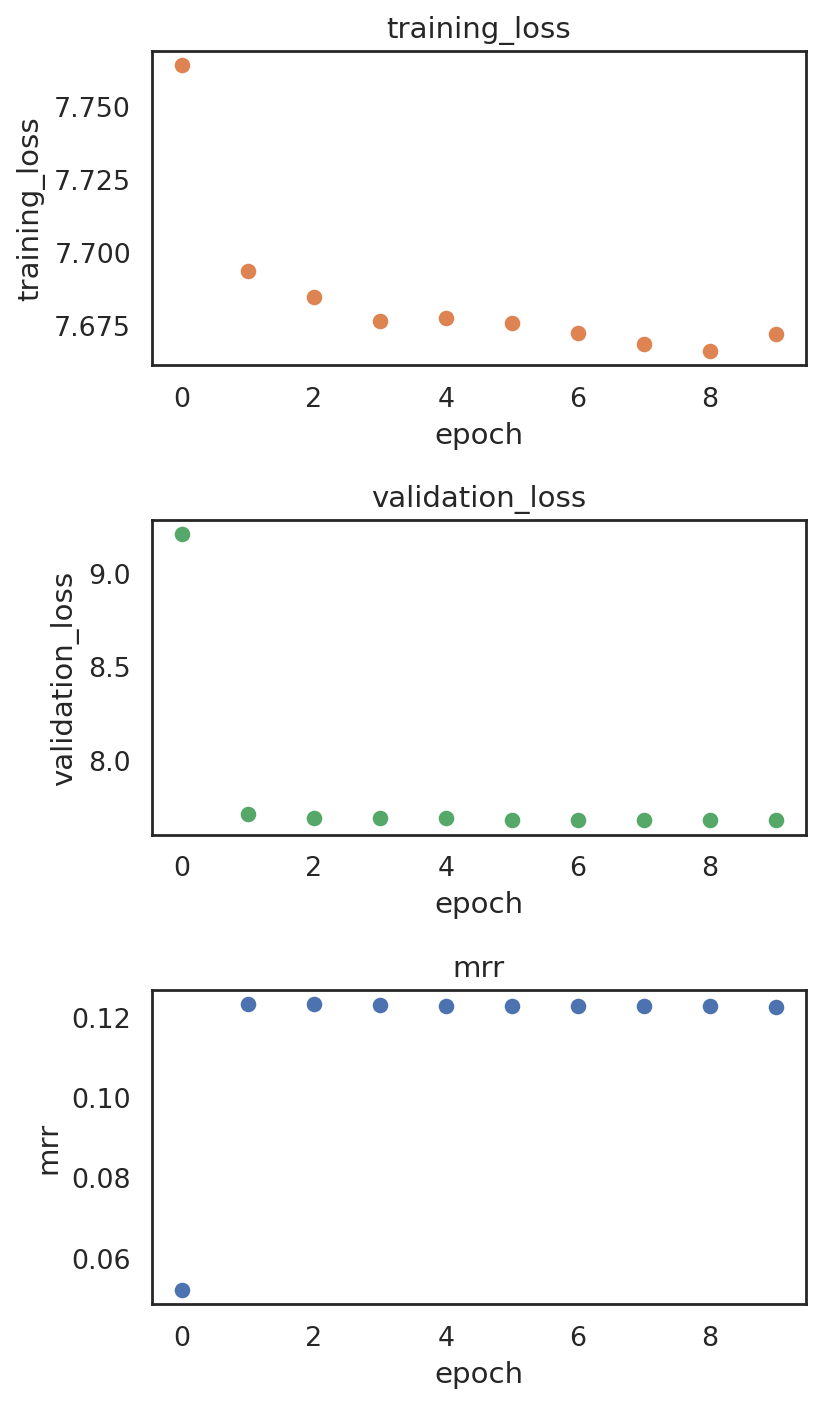

In [87]:
si.pl.pbg_metrics(fig_ncol=1)

In [88]:
# read in entity embeddings obtained from pbg training.
dict_adata = si.read_embedding()
dict_adata

{'C0': AnnData object with n_obs × n_vars = 4221 × 50}

In [89]:
adata_C0 = dict_adata['C0']  # embeddings of cells

In [90]:
adata_C0.obs['spatialLIBD'] = adata[adata_C0.obs_names,:].obs['spatialLIBD'].copy()
adata_C0.var.index = adata_C0.obs.index

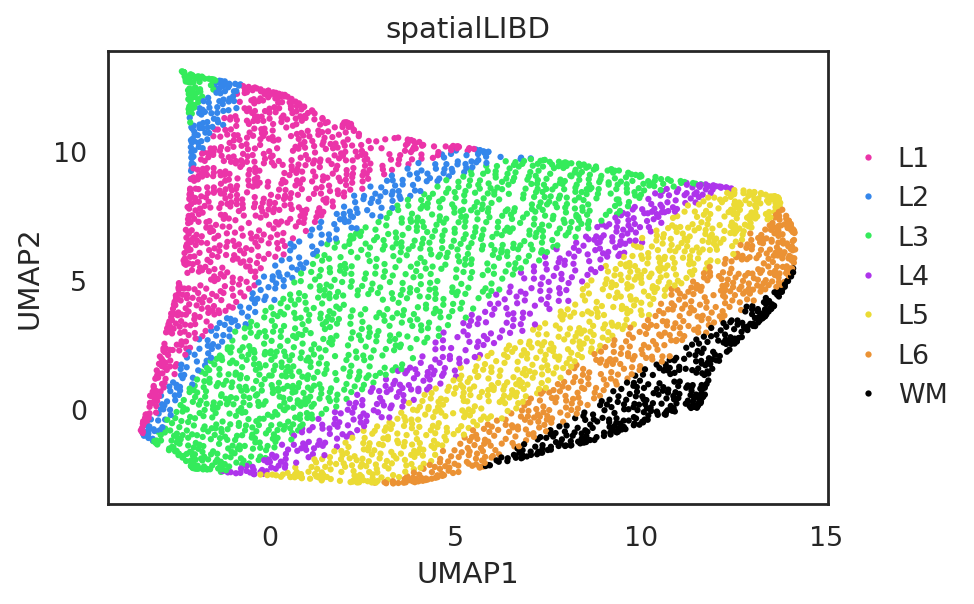

In [91]:
si.tl.umap(adata_C0,n_neighbors=15,n_components=2)
si.pl.umap(
    adata_C0,color=['spatialLIBD'],
    dict_palette={'spatialLIBD': palette_celltype},
    fig_size=(6,4),
    drawing_order='random'
)

# Add gene correlation

In [92]:
corrcoef_cov = np.corrcoef(adata.X.toarray())

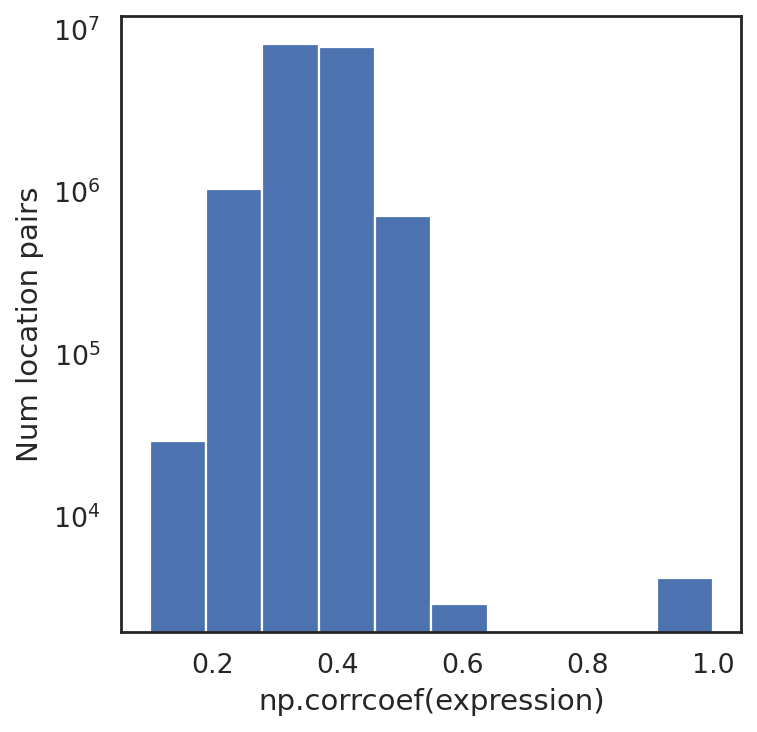

In [93]:
plt.hist(corrcoef_cov.flatten())
plt.xlabel('np.corrcoef(expression)')
plt.ylabel('Num location pairs')
plt.yscale('log')
plt.show()

In [107]:
adata_CC_corr = gen_spatial_graph(adata, e = 6, scalar=corrcoef_cov)

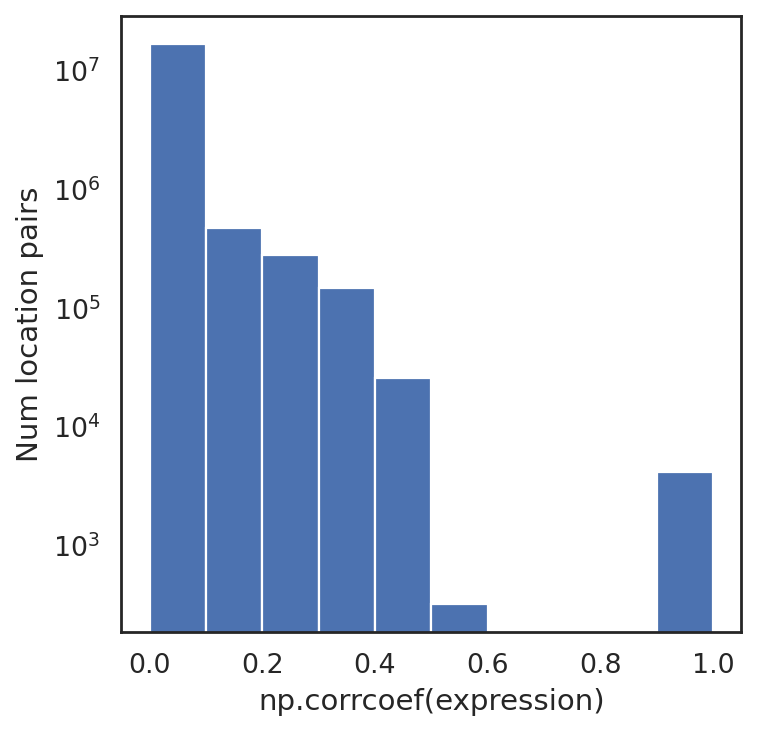

In [108]:
plt.hist(adata_CC_corr.X.toarray().flatten())
plt.xlabel('np.corrcoef(expression)')
plt.ylabel('Num location pairs')
plt.yscale('log')
plt.show()

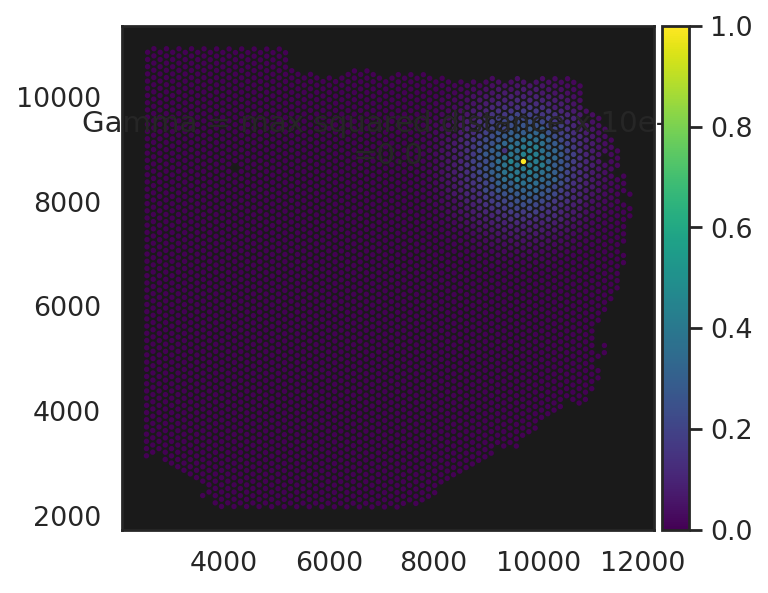

In [109]:
fig, ax = plt.subplots()
im = ax.scatter(adata_CC_corr.obsm['spatial'][:, 1], adata_CC_corr.obsm['spatial'][:, 0], c=adata_CC_corr.X.toarray()[1500], s=2)
ax.set_facecolor('k')
ax.set_aspect('equal', adjustable='box')
ax.set_title(f"Gamma = max squared distance x 10e-{e} \n={np.round(gamma, 2)}", y=0.7)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
plt.tight_layout()
plt.show()

In [110]:
si.tl.gen_graph(
    list_adata=[adata_CC_corr],
    prefix='C',
    # layer='simba',
    use_highly_variable=False, 
    dirname='graph_corr'
)

`simba` does not exist in adata 0 in `list_adata`.`.X` is being used instead.
relation0: source: C0, destination: C0
#edges: 17812651
Total number of edges: 17812651
Writing graph file "pbg_graph.txt" to "data/11/pbg/graph_corr" ...
Finished.


In [99]:
si.tl.pbg_train(auto_wd=True, save_wd=True, output='model_corr')

Auto-estimated weight decay is 6.124797E-03
`.settings.pbg_params['wd']` has been updated to 6.124797E-03
Converting input data ...
[2025-02-18 20:49:32.260300] Using the 1 relation types given in the config
[2025-02-18 20:49:32.260695] Searching for the entities in the edge files...
[2025-02-18 20:49:39.264547] Entity type C0:
[2025-02-18 20:49:39.265452] - Found 4221 entities
[2025-02-18 20:49:39.265726] - Removing the ones with fewer than 1 occurrences...
[2025-02-18 20:49:39.266491] - Left with 4221 entities
[2025-02-18 20:49:39.266706] - Shuffling them...
[2025-02-18 20:49:39.269039] Preparing counts and dictionaries for entities and relation types:
[2025-02-18 20:49:39.316040] - Writing count of entity type C0 and partition 0
[2025-02-18 20:49:39.516811] Preparing edge path data/11/pbg/graph_corr/input/edge, out of the edges found in data/11/pbg/graph_corr/pbg_graph.txt
using fast version
[2025-02-18 20:49:39.519239] Taking the fast train!
[2025-02-18 20:49:39.923500] - Processed

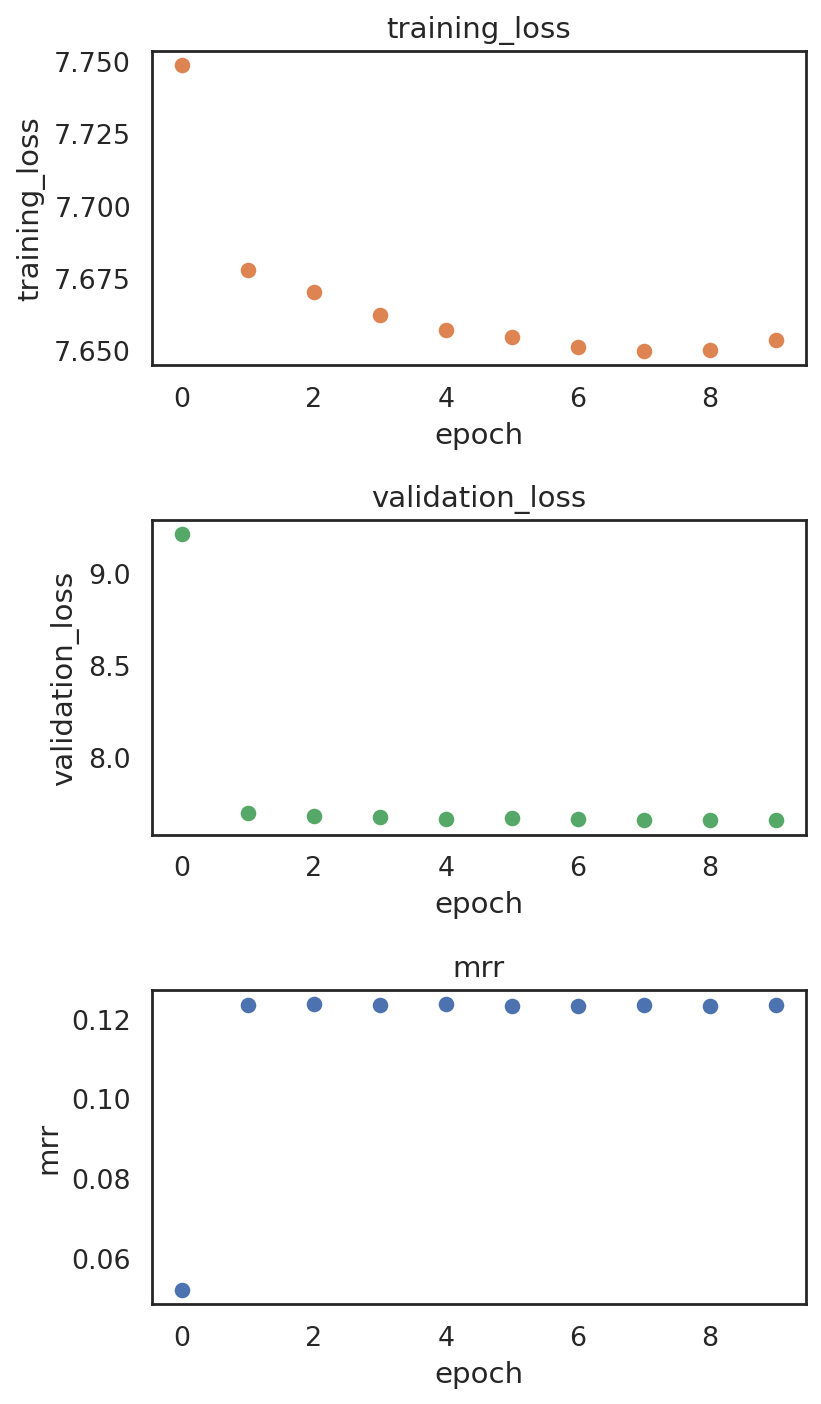

In [111]:
si.pl.pbg_metrics(fig_ncol=1)

In [112]:
# read in entity embeddings obtained from pbg training.
dict_adata_corr = si.read_embedding()
adata_C0_corr = dict_adata_corr['C0']  # embeddings of cells
adata_C0_corr.obs['spatialLIBD'] = adata[adata_C0_corr.obs_names,:].obs['spatialLIBD'].copy()
adata_C0_corr.var.index = adata_C0_corr.obs.index

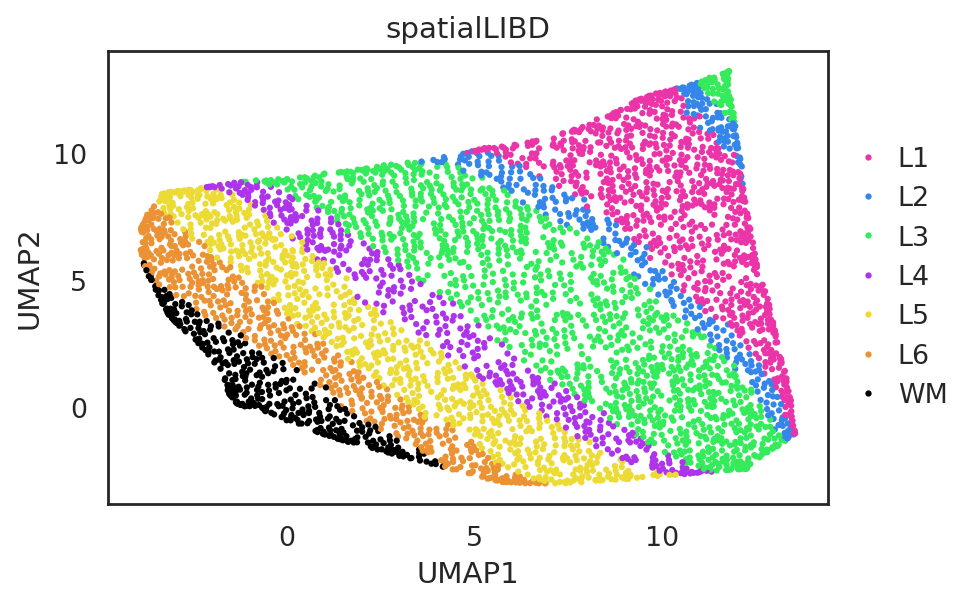

In [113]:
si.tl.umap(adata_C0_corr,n_neighbors=15,n_components=2)
si.pl.umap(
    adata_C0_corr,color=['spatialLIBD'],
    dict_palette={'spatialLIBD': palette_celltype},
    fig_size=(6,4),
    drawing_order='random'
)